In [ ]:
import pandas as pd
import random
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import sklearn

import matplotlib.pyplot as plt
import matplotlib

import pickle
import time

from pathlib import Path
import distro
%load_ext watermark

In [ ]:
# old one '1.8.1+cu111'
torch.__version__

'2.5.0+cu124'

In [ ]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import fix_all_seeds, train_loop
from text_embeddings_src.data_stuff import MultOverlappingSentencesPairDataset

In [ ]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [ ]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")

In [ ]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [ ]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [ ]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers -p openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-11-28 10:29:26CET

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.28.0

openTSNE: 1.0.2

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.18.0-553.el8_10.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

pandas             : 2.2.3
text_embeddings_src: 0.0.0
black              : 24.10.0
matplotlib         : 3.9.2
transformers       : 4.45.2
scipy              : 1.11.4
sklearn            : 1.5.2
torch              : 2.5.0
distro             : 1.9.0
jupyter_black      : 0.4.0
numpy              : 1.26.4
memory_profiler    : 0.61.0

Watermark: 2.5.0

Ubuntu 24.04 LTS


# Import

## ICLR

In [ ]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    engine="pyarrow",
)

CPU times: user 265 ms, sys: 82 ms, total: 347 ms
Wall time: 263 ms


In [ ]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [ ]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [ ]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

#  Reddit

## Get dataset

In [ ]:
dataset_name = "reddit"
dataset_path = "mteb/reddit-clustering-p2p"

In [ ]:
dataset = load_dataset(dataset_path)
dataset

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 10
    })
})

In [ ]:
sentences = list(
    np.hstack(dataset.data["test"].to_pandas().sentences.to_numpy())
)
# sentences = np.hstack(dataset.data["test"].to_pandas().sentences.to_numpy())
labels = list(np.hstack(dataset.data["test"].to_pandas().labels.to_numpy()))

In [ ]:
len(sentences)

459399

## Training on Reddit + further training on ICLR

In [ ]:
# select subset for training that yields the same loader length as the ICLR dataset (~360), in this case x3 times the original size
print(iclr2024.abstract.shape)
np.random.seed(42)
subset = np.random.choice(
    len(sentences),
    size=iclr2024.abstract.shape[0] * 3,
    replace=False,
)
reddit_subset = pd.Series(sentences).iloc[subset]
print(reddit_subset.shape)
print(type(reddit_subset))
print(type(iclr2024.abstract))

(24347,)
(73041,)
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# REDDIT TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    reddit_subset, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Reddit training loader length: ", len(training_loader))

losses, knn_accuracies, model_trained = train_loop_batches_eval(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(
    variables_path / saving_path / "losses_batches_train_reddit_eval_iclr_v3",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_reddit_eval_iclr_v3",
    knn_accuracies,
)


# ICLR TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("ICLR training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model_trained,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(
    variables_path
    / saving_path
    / "losses_batches_train_iclr_after_reddit_eval_iclr_v3",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_reddit_eval_iclr_v3",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Reddit training loader length:  357


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

#### Plot

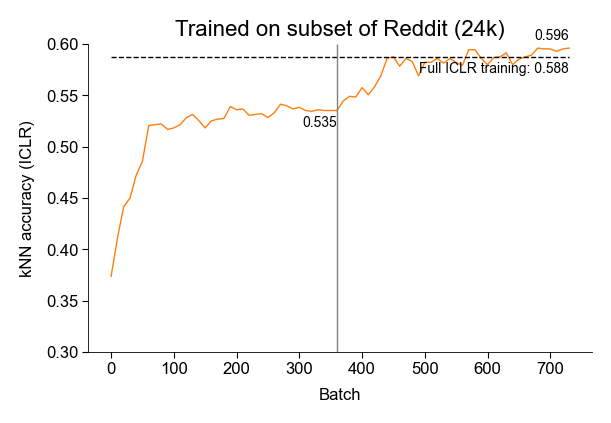

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200)

model_name = "MPNet"

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

knn_accuracies_after = np.load(
    variables_path / saving_path / "knn_accuracies_run1.npy"
)

knn_accuracies_iclr_train_reddit = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_reddit_eval_iclr_v3.npy",
)

knn_accuracies_iclr_train_iclr_after_reddit = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_reddit_eval_iclr_v3.npy",
)

y_lim_bottom = 0.3
y_lim_top = 0.6

# first half
last_x_1 = np.arange(len(knn_accuracies_iclr_train_reddit))[-1] * 10
ax.plot(
    np.arange(len(knn_accuracies_iclr_train_reddit)) * 10,
    np.vstack(knn_accuracies_iclr_train_reddit)[:, 0],
    label="Reddit",
    c="tab:orange",
)
ax.text(
    last_x_1,
    np.vstack(knn_accuracies_iclr_train_reddit)[:, 0][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr_train_reddit)[:, 0][-1]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)

# second half
last_x_2 = (
    last_x_1
    + np.arange(len(knn_accuracies_iclr_train_iclr_after_reddit))[-1] * 10
)

ax.plot(
    last_x_1
    + np.arange(len(knn_accuracies_iclr_train_iclr_after_reddit)) * 10,
    np.vstack(knn_accuracies_iclr_train_iclr_after_reddit)[:, 0],
    label="ICLR",
    color="tab:orange",
)
ax.text(
    last_x_2,
    np.vstack(knn_accuracies_iclr_train_iclr_after_reddit)[:, 0][-1] + 0.005,
    f"{np.vstack(knn_accuracies_iclr_train_iclr_after_reddit)[:, 0][-1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)

ax.hlines(knn_accuracies_after[0, 0], 0, last_x_2, color="k", linestyles="--")
ax.text(
    last_x_2,
    knn_accuracies_after[0, 0] - 0.005,
    f"Full ICLR training: {knn_accuracies_after[0,0]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)

ax.vlines(
    last_x_1,
    y_lim_bottom,
    y_lim_top,
    color="grey",
    # ls="--",
)
# ax.legend(loc="lower right")
ax.set_ylim(y_lim_bottom, y_lim_top)
ax.set_xlabel("Batch")
ax.set_ylabel("kNN accuracy (ICLR)")
ax.set_title("Trained on subset of Reddit (24k)")

fig.savefig(
    figures_path / "knn_accuracies_MPNet_batches_train_reddit_eval_iclr_v3.png"
)

# Biorxiv

## Get dataset

In [ ]:
dataset_name = "biorxiv"
dataset_path = "mteb/biorxiv-clustering-p2p"

In [ ]:
dataset = load_dataset(dataset_path)
dataset

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 53787
    })
})

In [ ]:
sentences = list(
    np.hstack(dataset.data["test"].to_pandas().sentences.to_numpy())
)
labels = list(np.hstack(dataset.data["test"].to_pandas().labels.to_numpy()))

In [ ]:
len(sentences)

53787

## Random subset

Also using a different augmentation than the experimetn above

## Training on biorxiv + further training on ICLR

In [ ]:
# select subset for training that yields the same loader length as the ICLR dataset (~360), in this case same size
print(iclr2024.abstract.shape)
np.random.seed(42)
subset = np.random.choice(
    len(sentences),
    size=iclr2024.abstract.shape[0],
    replace=False,
)
biorxiv_subset = pd.Series(sentences).iloc[subset]
print(biorxiv_subset.shape)
print(type(biorxiv_subset))
print(type(iclr2024.abstract))

(24347,)
(24347,)
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# BIORXIV TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    biorxiv_subset, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

print("Biorxiv training loader length: ", len(training_loader))

losses, knn_accuracies, model_trained = train_loop_batches_eval(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(
    variables_path / saving_path / "losses_batches_train_biorxiv_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_biorxiv_eval_iclr_v1",
    knn_accuracies,
)


# ICLR TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("ICLR training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model_trained,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(
    variables_path
    / saving_path
    / "losses_batches_train_iclr_after_biorxiv_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_biorxiv_eval_iclr_v1",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Biorxiv training loader length:  369


  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

ICLR training loader length:  368


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

CPU times: user 6h 43min 55s, sys: 24min 47s, total: 7h 8min 42s
Wall time: 4h 31min 18s


#### Plot

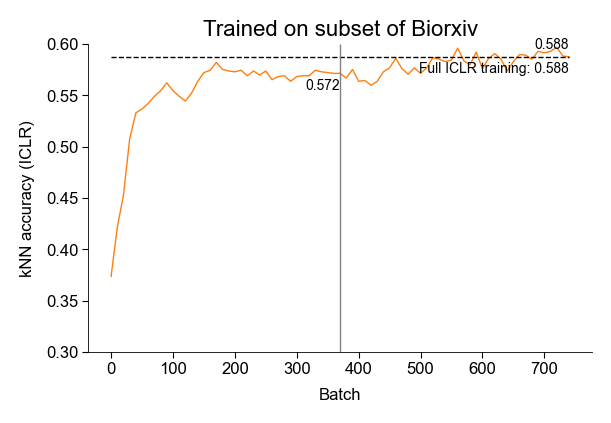

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200)

model_name = "MPNet"

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

knn_accuracies_after = np.load(
    variables_path / saving_path / "knn_accuracies_run1.npy"
)

knn_accuracies_iclr_train_ = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_biorxiv_eval_iclr_v1.npy",
)

knn_accuracies_iclr_train_iclr_after_ = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_biorxiv_eval_iclr_v1.npy",
)

y_lim_bottom = 0.3
y_lim_top = 0.6

# first half
last_x_1 = np.arange(len(knn_accuracies_iclr_train_))[-1] * 10
ax.plot(
    np.arange(len(knn_accuracies_iclr_train_)) * 10,
    np.vstack(knn_accuracies_iclr_train_)[:, 0],
    label="Biorxiv",
    c="tab:orange",
)
ax.text(
    last_x_1,
    np.vstack(knn_accuracies_iclr_train_)[:, 0][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr_train_)[:, 0][-1]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)

# second half
last_x_2 = (
    last_x_1 + np.arange(len(knn_accuracies_iclr_train_iclr_after_))[-1] * 10
)

ax.plot(
    last_x_1 + np.arange(len(knn_accuracies_iclr_train_iclr_after_)) * 10,
    np.vstack(knn_accuracies_iclr_train_iclr_after_)[:, 0],
    label="ICLR",
    color="tab:orange",
)
ax.text(
    last_x_2,
    np.vstack(knn_accuracies_iclr_train_iclr_after_)[:, 0][-1] + 0.005,
    f"{np.vstack(knn_accuracies_iclr_train_iclr_after_)[:, 0][-1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)

ax.hlines(knn_accuracies_after[0, 0], 0, last_x_2, color="k", linestyles="--")
ax.text(
    last_x_2,
    knn_accuracies_after[0, 0] - 0.005,
    f"Full ICLR training: {knn_accuracies_after[0,0]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)

ax.vlines(
    last_x_1,
    y_lim_bottom,
    y_lim_top,
    color="grey",
    # ls="--",
)
# ax.legend(loc="lower right")
ax.set_ylim(y_lim_bottom, y_lim_top)
ax.set_xlabel("Batch")
ax.set_ylabel("kNN accuracy (ICLR)")
ax.set_title("Trained on subset of Biorxiv")

fig.savefig(
    figures_path
    / "knn_accuracies_MPNet_batches_train_biorxiv_eval_iclr_v1.png"
)

# Arxiv

## Get dataset

In [ ]:
dataset_name = "arxiv"
dataset_path = "mteb/arxiv-clustering-p2p"

In [ ]:
dataset = load_dataset(dataset_path)
dataset

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 31
    })
})

In [ ]:
sentences = list(
    np.hstack(dataset.data["test"].to_pandas().sentences.to_numpy())
)
labels = list(np.hstack(dataset.data["test"].to_pandas().labels.to_numpy()))

## Random subset

Also using a different augmentation than the experimetn above

## Training on arxiv + further training on ICLR

In [ ]:
# select subset for training that yields the same loader length as the ICLR dataset (~360), in this case x1.2 the size
print(iclr2024.abstract.shape)
np.random.seed(42)
subset = np.random.choice(
    len(sentences),
    size=int(iclr2024.abstract.shape[0] * 1.2),
    replace=False,
)
arxiv_subset = pd.Series(sentences).iloc[subset]
print(arxiv_subset.shape)
print(type(arxiv_subset))
print(type(iclr2024.abstract))

(24347,)
(29216,)
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# ARXIV TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    arxiv_subset, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

print("Arxiv training loader length: ", len(training_loader))

losses, knn_accuracies, model_trained = train_loop_batches_eval(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(
    variables_path / saving_path / "losses_batches_train_arxiv_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_arxiv_eval_iclr_v1",
    knn_accuracies,
)


# ICLR TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("ICLR training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model_trained,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(
    variables_path
    / saving_path
    / "losses_batches_train_iclr_after_arxiv_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_arxiv_eval_iclr_v1",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


Arxiv training loader length:  338


  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

ICLR training loader length:  368


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

CPU times: user 6h 24min 42s, sys: 26min 32s, total: 6h 51min 15s
Wall time: 4h 24min 7s


#### Plot

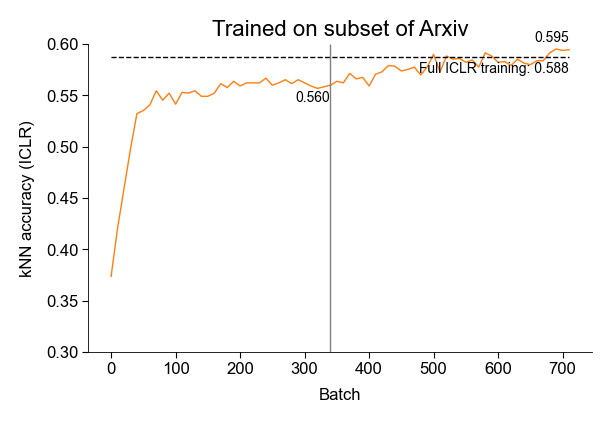

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200)

model_name = "MPNet"

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

knn_accuracies_after = np.load(
    variables_path / saving_path / "knn_accuracies_run1.npy"
)

knn_accuracies_iclr_train_ = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_arxiv_eval_iclr_v1.npy",
)

knn_accuracies_iclr_train_iclr_after_ = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_arxiv_eval_iclr_v1.npy",
)

y_lim_bottom = 0.3
y_lim_top = 0.6

# first half
last_x_1 = np.arange(len(knn_accuracies_iclr_train_))[-1] * 10
ax.plot(
    np.arange(len(knn_accuracies_iclr_train_)) * 10,
    np.vstack(knn_accuracies_iclr_train_)[:, 0],
    label="Arxiv",
    c="tab:orange",
)
ax.text(
    last_x_1,
    np.vstack(knn_accuracies_iclr_train_)[:, 0][-1] - 0.005,
    f"{np.vstack(knn_accuracies_iclr_train_)[:, 0][-1]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)

# second half
last_x_2 = (
    last_x_1 + np.arange(len(knn_accuracies_iclr_train_iclr_after_))[-1] * 10
)

ax.plot(
    last_x_1 + np.arange(len(knn_accuracies_iclr_train_iclr_after_)) * 10,
    np.vstack(knn_accuracies_iclr_train_iclr_after_)[:, 0],
    label="ICLR",
    color="tab:orange",
)
ax.text(
    last_x_2,
    np.vstack(knn_accuracies_iclr_train_iclr_after_)[:, 0][-1] + 0.005,
    f"{np.vstack(knn_accuracies_iclr_train_iclr_after_)[:, 0][-1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)

ax.hlines(knn_accuracies_after[0, 0], 0, last_x_2, color="k", linestyles="--")
ax.text(
    last_x_2,
    knn_accuracies_after[0, 0] - 0.005,
    f"Full ICLR training: {knn_accuracies_after[0,0]:.3f}",
    fontsize=5,
    va="top",
    ha="right",
)

ax.vlines(
    last_x_1,
    y_lim_bottom,
    y_lim_top,
    color="grey",
    # ls="--",
)
# ax.legend(loc="lower right")
ax.set_ylim(y_lim_bottom, y_lim_top)
ax.set_xlabel("Batch")
ax.set_ylabel("kNN accuracy (ICLR)")
ax.set_title("Trained on subset of Arxiv")

fig.savefig(
    figures_path / "knn_accuracies_MPNet_batches_train_arxiv_eval_iclr_v1.png"
)